[GitHub_(MyProject)](https://github.com/Stelios-prog/Rock-Scissors-Paper-Agent)

# Stylianos Papargyris
# AEM: 140

# Final Project 2023

# Rock-Scissors-Paper Agent

# Περιγραφή

Στόχος του
project είναι η κατασκευή ενός ευφυούς πράκτορα που θα μάθει να παίζει το παιχνίδι Rock
Scissor paper. Ποιο συγκεκριμένα, ο πράκτορας θα βλέπει μία εικόνα που αντιστοιχεί σε 0: Πέτρα ( Rock),
1: Ψαλίδι ( Scissor) ή 2: Χαρτί ( Paper) και θ α επιλέγει το αντίστοιχο σύμβολο που το κερδίζει.
Για την εκπαίδευση του πράκτορα σας, μπορείτε να χρησιμοποιήσετε το παρακάτω σύνολο δεδομένων
:
https://www.kaggle.com/datasets/drgfreeman/rockpaperscissors
το οποίο
περιέχει 700+ εικόνες για κάθε κίνηση

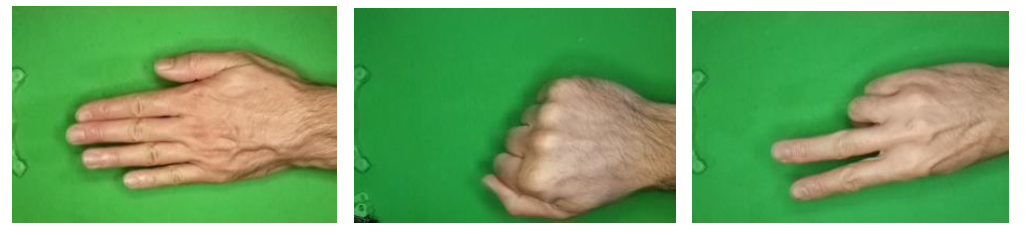

# Οδηγίες Παιχνιδιού

Ο δικός σας πράκτορας θα ποντάρει 1€ εναντίων ενός
Random Agent για συνολικά Ν γύρους. Αν ο
πράκτορας σας κερδίσει, του επιστρέφονται 2€, στην ισοπαλία του επιστρέφεται 1€, διαφορετικά έχει
χάσει 1€. Ο Random Agent θα παίζει πάντα 1 ος , διαλέγοντας μία τυχαία εικόνα από τις 2100 εικόνες
συνολικά (μπορεί να είναι είτε χαρτί, είτε πέτρα, είτε ψαλίδι).
Επειδή ο
Random Agent είναι πονηρός, μπορεί να εφαρμόσει vertical flip με πιθανότητα 𝑝 1 0 5 και
ύστερα με πιθανότητα 𝑝 2 0 5 μπορεί εφαρμόζει horizontal flip Τέλος, ο Random Agent εφαρμόζει
τυχαίο θόρυβο ( white noise σε κάθε pixel της εικόνας με μέση τιμή 0 και τυπική απόκλιση 5 % της
μέγιστης τιμής του pixel. Η λειτουργία του Random Agent μπορεί να περιγραφεί ως:

# Install Libraries

# Functions

In [ ]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import random
import tensorflow as tf


# Function to load images and labels
def load_data(directory, labels, exclude_folder):
    images = []
    image_labels = []

    # Iterate over the folders in the directory
    for label, num_label in labels.items():
        folder_path = os.path.join(directory, label)

        if os.path.basename(folder_path) == exclude_folder:
            # Skip the excluded folder
            continue

        for image_file in os.listdir(folder_path):
            if image_file.lower().endswith(('.png')):
                image_path = os.path.join(folder_path, image_file)
                image = load_img(image_path, target_size=(224, 224))
                image_array = img_to_array(image)
                image_array /= 255.0  # Normalize the image
                images.append(image_array)
                image_labels.append(num_label)

    return np.array(images), np.array(image_labels)


# Function to apply random flips and noise to the image
def preprocess_image(image):
    # Randomly apply vertical and horizontal flips
    if random.random() < 0.5:
        image = tf.image.flip_left_right(image)
    if random.random() < 0.5:
        image = tf.image.flip_up_down(image)
    # Add random noise
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.05, dtype=tf.float32)
    image += noise
    image = tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)
    return image


# Function to make the agent's decision
def make_decision(model, img):
    noisy_img = preprocess_image(img)
    prediction = model.predict(np.expand_dims(noisy_img, axis=0))
    predicted_class = np.argmax(prediction)

    # Define a mapping from the predicted class to the winning move
    winning_moves = {0: 2, 1: 0, 2: 1}  # rock(0) -> paper(2), scissors(1) -> rock(0), paper(2) -> scissors(1)
    winning_move = winning_moves[predicted_class]
    return winning_move


# Function to simulate the agent's decision in one round
def play_one_round(model, X_test, y_test):
    # Select a random image and preprocess it
    random_idx = np.random.choice(len(X_test))
    image = X_test[random_idx]
    true_label = y_test[random_idx]

    # Predict the move
    predicted_move = make_decision(model, image)

    # Define winning relationships (rock: 0, scissors: 1, paper: 2)
    winning_moves = {0: 1, 1: 2, 2: 0}


    # Determine the outcome and calculate profit
    if predicted_move == true_label:
        return 0  # Draw
    elif winning_moves[predicted_move] == true_label:
        return 1  # Win
    else:
        return -1  # Lose


# Function to play multiple rounds
def play_game(rounds, model, X_test, y_test):
    profits = []
    for _ in range(rounds):
        profit = play_one_round(model, X_test, y_test)
        profits.append(profit if profits == [] else profits[-1] + profit)
    return profits

# My_Model

The choice of a CNN for a Rock-Paper-Scissors agent is driven by the CNN's ability to directly process and classify images, its effectiveness in feature extraction, its robustness to variations in input, and its potential for high accuracy. These characteristics make it highly suitable for image-based classification tasks, such as identifying hand gestures in the Rock-Paper-Scissors game.

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam

def create_model(input_shape):
    # Define the model architecture
    model = Sequential([
        Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dropout(0.5),
        Dense(512, activation='relu'),
        Dense(3, activation='softmax')  # 3 classes for rock, paper, scissors
    ])

    # Compile the model
    model.compile(optimizer=Adam(lr=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model


In [ ]:
#!unzip archive.zip -d archive

Archive:  archive.zip
replace archive/README_rpc-cv-images.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Main

Default GPU Device: /device:GPU:0


Epoch 1/100
47/47 [==============================] - ETA: 0s - loss: 1.1174 - accuracy: 0.3689
Epoch 1: val_loss improved from inf to 1.04641, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


47/47 [==============================] - 29s 439ms/step - loss: 1.1174 - accuracy: 0.3689 - val_loss: 1.0464 - val_accuracy: 0.4394 - lr: 0.0010
Epoch 2/100
47/47 [==============================] - ETA: 0s - loss: 1.0332 - accuracy: 0.4330
Epoch 2: val_loss improved from 1.04641 to 0.89237, saving model to best_model.h5
47/47 [==============================] - 20s 432ms/step - loss: 1.0332 - accuracy: 0.4330 - val_loss: 0.8924 - val_accuracy: 0.5835 - lr: 0.0010
Epoch 3/100
47/47 [==============================] - ETA: 0s - loss: 1.0182 - accuracy: 0.4777
Epoch 3: val_loss improved from 0.89237 to 0.74945, saving model to best_model.h5
47/47 [==============================] - 19s 402ms/step - loss: 1.0182 - accuracy: 0.4777 - val_loss: 0.7494 - val_accuracy: 0.7025 - lr: 0.0010
Epoch 4/100
47/47 [==============================] - ETA: 0s - loss: 0.7484 - accuracy: 0.6711
Epoch 4: val_loss improved from 0.74945 to 0.39060, saving model to best_model.h5
47/47 [===========================

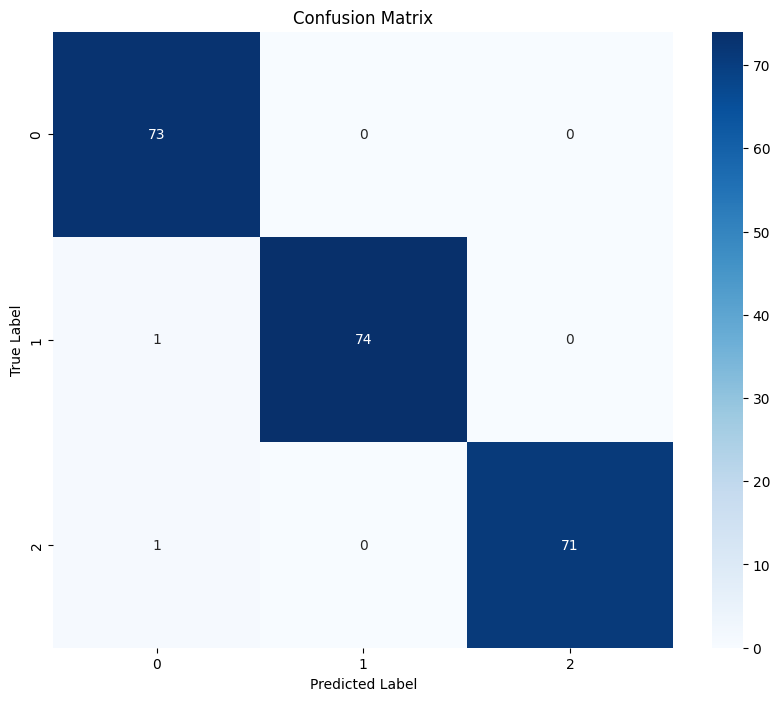

1/1 [==============================] - 0s 17ms/step


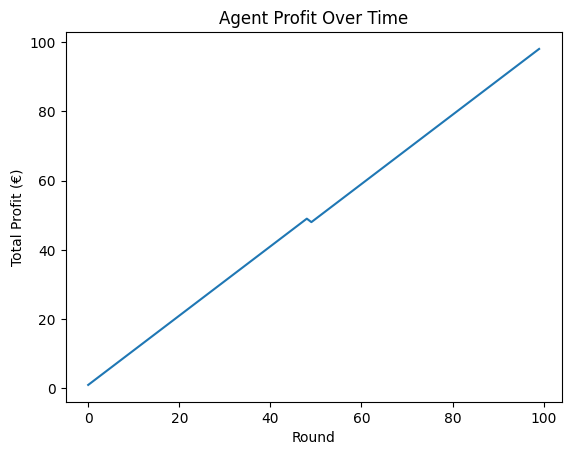

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random

# from functions import load_data, preprocess_image, play_game, make_decision
# from my_model import create_model

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

# Assign numerical values to the moves
labels = {'rock': 0, 'scissors': 1, 'paper': 2}
data_dir = 'archive'
exclude_folder = 'rps-cv-images'

# Load the data
images, image_labels = load_data(data_dir, labels, exclude_folder)

# Split the data into 70% training, 20% validation, and 10% testing sets
X_train, X_temp, y_train, y_temp = train_test_split(
    images, image_labels, test_size=0.3, stratify=image_labels, random_state=42)
test_size_proportion = 0.1 / 0.3
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=test_size_proportion, stratify=y_temp, random_state=42)

# Model creation
input_shape = X_train.shape[1:]  # This will be (224, 224, 3)
model = create_model(input_shape)

# Callbacks for training
callbacks = [ModelCheckpoint("best_model.h5", save_best_only=True, verbose=1),
             ReduceLROnPlateau(factor=0.33, patience=2,verbose=1),
             EarlyStopping(patience=5, verbose=1)]

# Data augmentation generator
train_datagen = ImageDataGenerator(
    rotation_range=60,  # degrees
    width_shift_range=0.2,  # fraction of total width
    height_shift_range=0.2,  # fraction of total height
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)

# Training the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,  # Number of batches per epoch
    epochs=100,
    callbacks=callbacks,
    validation_data=(X_val, y_val)
)

# Load the best model and evaluate on the test set
model = load_model("best_model.h5")
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("test_loss:", test_loss, "test_acc:", test_accuracy)

# Generate predictions for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Play the game for N rounds
N = 100
profits_over_time = play_game(N, model, X_test, y_test)

# Plot the agent's profit over time
plt.plot(profits_over_time)
plt.title('Agent Profit Over Time')
plt.xlabel('Round')
plt.ylabel('Total Profit (€)')
plt.show()
